In [79]:
#Python Packages
import pandas as pd
import numpy as np
import xarray as xr
import glob as gb 
import csv
import itertools
from pathlib import Path
from pandas import *
import os.path
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [139]:
#Load in functions from freelymoving ephys
import sys
sys.path.insert(0, 'C:/Users/nlab/Documents/GitHub/FreelyMovingEphys')
from utils.paths import find
from utils.time import open_time1
from utils.time import open_time
from utils.format_data import open_h5
from utils.format_data import open_ma_h5

#function to get correct frame in case there's lag in the acquisition
def find_first(item, vec):
    return np.argmin(np.abs(vec-item))

ModuleNotFoundError: No module named 'cv2'

In [154]:
##Load Data
# Dictionary of columns in data frame
data_dict = {'date': [],
             'animal': [],
             'task': [],             
             'poke1_ts':[],
             'poke2_ts': [],
             'spout1_ts': [],
             'spout2_ts': [],
             'top1_ts': [],
             'poke1_t0':[],
             'poke2_t0': [],
             'spout1_t0': [],
             'spout2_t0': [],
             'top1_t0': []}
# List of dates for analysis
dates= ['090621','090721','090821']
data_path = Path('~/Desktop/mike_bonsai/recordings/').expanduser()
all_paths = []
#Populate Data Dict with meta data and timestamps   
for date in dates:
    for ani in os.listdir(data_path / date): 
        data_paths = list((data_path / date/ ani).rglob('*.csv'))
        if data_paths != []:
            data_dict['date'].append(data_paths[1].name.split('_')[0])
            data_dict['animal'].append(data_paths[1].name.split('_')[1])
            data_dict['task'].append(data_paths[1].name.split('_')[4])
            for ind, csv in enumerate(data_paths):
                data_dict[data_paths[ind].name.split('_')[5] +'_ts'].append(open_time(csv))
                data_dict[data_paths[ind].name.split('_')[5] +'_t0'].append(open_time(csv)[0])
df = pd.DataFrame.from_dict(data_dict)
#df = df.transpose()


#df = pd.DataFrame(data_dict)

In [158]:
#Align to 
df.poke1_ts = df.poke1_ts - df.top1_t0
df.poke2_ts = df.poke2_ts - df.top1_t0
df.spout1_ts = df.spout1_ts - df.top1_t0
df.spout2_ts = df.spout2_ts - df.top1_t0

In [159]:
#Only spout on ts 
spout1_on = []
for ind, row in df.iterrows():
    x = row['spout1_ts']
    x = x[0::2]
    spout1_on.append(x)
df['spout1_on'] = spout1_on

In [160]:
#Get all pokes_ts
pokes_ts = []
for ind, row in df.iterrows():
    x = row['poke1_ts'].astype(str).astype(float)
    y = row['poke2_ts'].astype(str).astype(float)
    z = list(itertools.chain(x,y)) 
    z = sorted(z)
    pokes_ts.append(z)
df['pokes_ts'] = pokes_ts

In [161]:
# Number of pokes 
pokes = []
for ind, row in df.iterrows():
    x = row['pokes_ts']
    x=len(x)
    pokes.append(x)
df['poke_num'] = pokes

In [162]:
# Time between pokes in sec
time_between_pokes = []
for ind, row in df.iterrows():
    g = row['pokes_ts']
    g = np.diff(g)
    #g = g[0::2]
    
    time_between_pokes.append(g)
df['time_between_pokes'] = time_between_pokes


In [163]:
#Get 'trials'
## add 
trial_ts = []
for ind, row in df.iterrows():
    x = row['pokes_ts']#.astype(str).astype(float)
    y = [x[i:i+2] for i in range(0, len(x), 2)]
    z =  [x[i+1:i+3] for i in range(0, len(x), 2)]
    t = sorted(y+z)
    trial_ts.append(t)
df['trial_ts']= trial_ts


In [164]:
len(y)

93

In [165]:
len(z)

93

In [166]:
len(t)

186

In [167]:
a = df['time_between_pokes'].iloc[5]
len(a)

184

In [168]:
#Get 'trials #'
trial_num = []
for ind, row in df.iterrows():
    x = row['trial_ts']#.astype(str).astype(float)
    y=len(x)
    trial_num.append(y)
df['trial_num']= trial_num

In [169]:
df

,date,animal,task,poke1_ts,poke2_ts,spout1_ts,spout2_ts,top1_ts,poke1_t0,poke2_t0,spout1_t0,spout2_t0,top1_t0,spout1_on,pokes_ts,poke_num,time_between_pokes,trial_ts,trial_num
0,090621,G6CK3LT,oa,"[9.012454999996407, 32.02147899999545, 45.6623...","[20.220095999997284, 38.919487999999546, 51.73...","[9.012786999999662, 11.018559999996796, 32.021...","[20.22056999999768, 22.234534999995958, 38.919...","[45903.962457, 45903.978739, 45903.995366, 459...",45912.974912,45924.182553,45912.975244,45924.183027,45903.962457,"[9.012786999999662, 32.021810999998706, 45.662...","[9.012454999996407, 20.220095999997284, 32.021...",137,"[11.207641000000876, 11.801382999998168, 6.898...","[[], [9.012454999996407, 20.220095999997284], ...",138
1,090621,G6CK3RT,oa,"[2.4534399999974994, 68.27412499999627, 90.983...","[48.25061199999618, 85.40002600000298, 98.0330...","[2.4537990000026184, 4.454976000000897, 68.274...","[48.25091899999825, 50.25673000000097, 85.4003...","[47774.940876, 47774.955609, 47774.972275, 477...",47777.394316,47823.191488,47777.394675,47823.191795,47774.940876,"[2.4537990000026184, 68.27447099999699, 90.983...","[2.4534399999974994, 48.25061199999618, 68.274...",108,"[45.79717199999868, 20.023513000000094, 17.125...","[[2.4534399999974994, 48.25061199999618], [48....",108
2,090721,G6CK3LT,oa,"[8.237785999997868, 19.96965099999943, 32.1687...","[14.271667000000889, 25.425920000001497, 36.06...","[8.238130999998248, 9.748711000000185, 19.9699...","[14.272000000004482, 15.776192000004812, 25.42...","[56493.150937, 56493.165504, 56493.18222, 5649...",56501.388723,56507.422604,56501.389068,56507.422937,56493.150937,"[8.238130999998248, 19.969970999998623, 32.169...","[8.237785999997868, 14.271667000000889, 19.969...",152,"[6.033881000003021, 5.6979839999985415, 5.4562...","[[8.237785999997868, 14.271667000000889], [14....",152
3,090721,G6CK3RT,oa,"[24.342899999996007, 45.36921599999914, 71.233...","[35.972365000001446, 56.71614799999952, 76.198...","[24.34339899999759, 25.854489999997895, 45.369...","[35.972735999996075, 37.484262999998464, 56.71...","[55053.940748, 55053.962022, 55053.973849, 550...",55078.283648,55089.913113,55078.284147,55089.913484,55053.940748,"[24.34339899999759, 45.369535999998334, 71.233...","[24.342899999996007, 35.972365000001446, 45.36...",124,"[11.629465000005439, 9.396850999997696, 11.346...","[[24.342899999996007, 35.972365000001446], [35...",124
4,090821,G6CK3LT,oa,"[1.0935939999981201, 25.23863100000017, 35.657...","[6.582515000001877, 30.152602000001934, 39.500...","[1.0941309999980149, 2.3597700000027544, 25.23...","[6.582835000001069, 7.839181000003009, 30.1528...","[47914.121945, 47914.132441, 47914.149056, 479...",47915.215539,47920.704460,47915.216076,47920.704780,47914.121945,"[1.0941309999980149, 25.238976000000548, 35.65...","[1.0935939999981201, 6.582515000001877, 25.238...",177,"[5.4889210000037565, 18.656115999998292, 4.913...","[[], [1.0935939999981201, 6.582515000001877], ...",178
5,090821,G6CK3RT,oa,"[1.0785919999980251, 25.66050600000017, 43.196...","[18.95087400000193, 31.14964499999769, 47.9934...","[1.0789890000014566, 2.3346440000022994, 25.66...","[18.951398999997764, 20.2091270000019, 31.1500...","[49237.218124, 49237.232934, 49237.2496, 49237...",49238.296716,49256.168998,49238.297113,49256.169523,49237.218124,"[1.0789890000014566, 25.66082599999936, 43.197...","[1.0785919999980251, 18.95087400000193, 25.660...",185,"[17.872282000003906, 6.709631999998237, 5.4891...","[[], [1.0785919999980251, 18.95087400000193], ...",186


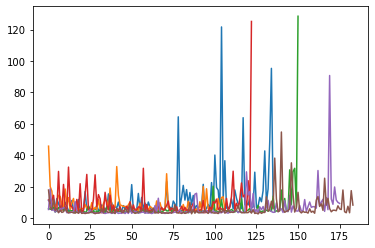

In [153]:
x = df['time_between_pokes'].apply(plt.plot)

In [70]:
y = df['top1_ts'].apply(len)

In [122]:
x=df['time_between_pokes'].iloc[4]

(array([141.,   4.,   2.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  3.129907 ,   9.3997336,  15.6695602,  21.9393868,  28.2092134,
         34.47904  ,  40.7488666,  47.0186932,  53.2885198,  59.5583464,
         65.828173 ,  72.0979996,  78.3678262,  84.6376528,  90.9074794,
         97.177306 , 103.4471326, 109.7169592, 115.9867858, 122.2566124,
        128.526439 ]),
 <BarContainer object of 20 artists>)

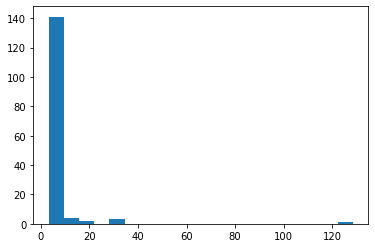

In [123]:
plt.hist(x,bins=20)

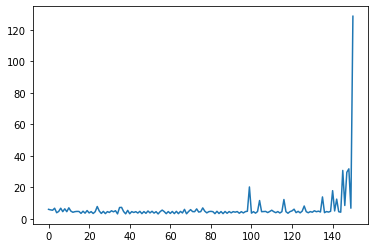

In [124]:
plt.plot(x)

In [125]:
x/y

array([0.03244022, 0.03063432, 0.02933478, 0.0362516 , 0.02092112,
       0.0252608 , 0.03625146, 0.02459878, 0.03418075, 0.02446506,
       0.03764005, 0.02644962, 0.02239876, 0.02457559, 0.02537208,
       0.02517258, 0.01874044, 0.02601586, 0.01944176, 0.02827823,
       0.02015078, 0.02462252, 0.01834501, 0.02448929, 0.0420648 ,
       0.02662551, 0.01847845, 0.0254795 , 0.01786254, 0.02468659,
       0.02180246, 0.0275308 , 0.02404969, 0.02772727, 0.01700163,
       0.03867314, 0.03909133, 0.02488596, 0.01711174, 0.02896131,
       0.01748466, 0.02466725, 0.02166958, 0.02457799, 0.01979926,
       0.02565705, 0.01784011, 0.0248426 , 0.01894049, 0.02684711,
       0.02030383, 0.02583335, 0.0196449 , 0.02448819, 0.01682746,
       0.02451138, 0.02988628, 0.024798  , 0.01764074, 0.02486393,
       0.0184799 , 0.02519226, 0.01790527, 0.02559091, 0.01768561,
       0.02539155, 0.02010715, 0.03228676, 0.01726645, 0.02490674,
       0.03147231, 0.02473187, 0.02444442, 0.03398406, 0.02316

In [126]:
x

array([  6.033881,   5.697984,   5.456269,   6.742797,   3.891328,
         4.698509,   6.742771,   4.575373,   6.357619,   4.550502,
         7.00105 ,   4.919629,   4.166169,   4.57106 ,   4.719206,
         4.682099,   3.485722,   4.83895 ,   3.616167,   5.25975 ,
         3.748045,   4.579789,   3.412172,   4.555008,   7.824052,
         4.952345,   3.436992,   4.739187,   3.322432,   4.591706,
         4.055258,   5.120729,   4.473242,   5.157273,   3.162304,
         7.193204,   7.270988,   4.628788,   3.182784,   5.386803,
         3.252147,   4.588109,   4.030541,   4.571507,   3.682662,
         4.772211,   3.31826 ,   4.620723,   3.522931,   4.993562,
         3.776512,   4.805004,   3.653952,   4.554804,   3.129907,
         4.559117,   5.558848,   4.612428,   3.281178,   4.624691,
         3.437261,   4.68576 ,   3.330381,   4.75991 ,   3.289523,
         4.722829,   3.73993 ,   6.005337,   3.211559,   4.632653,
         5.853849,   4.600128,   4.546663,   6.321036,   4.308

In [127]:
z = df.trial_num


In [128]:
z

0    142
1    114
2    138
3    108
4    152
5    124
6    178
7    186
Name: trial_num, dtype: int64

In [129]:
1/z

0    0.007042
1    0.008772
2    0.007246
3    0.009259
4    0.006579
5    0.008065
6    0.005618
7    0.005376
Name: trial_num, dtype: float64

In [156]:
x = open_h5('r:Users\nlab\Desktop\mike_bonsai\recordings\090221\G6CK3BLT\oa\090221_G6CK3BLT_control_Rig2_oa_top1DLC_resnet50_object_avoidanceAug31shuffle1_200000.h5')

NameError: name 'open_h5' is not defined

In [172]:
len(df.trial_ts[5])

186

In [174]:
df.trial_num[5]

186